In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import GaussianBlur, ToTensor, ToPILImage, RandomCrop, Compose, Resize, Normalize
from torchvision.datasets import CIFAR10, Flickr8k, CelebA
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001
image_size = 28

# Gaussian Pyramid Constants
num_scales = 3
scale_factor = 2

# Define the network architecture
class CompletionModel(nn.Module):
    def __init__(self):
        super(CompletionModel, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
#         print(x.shape)
        encoded = self.encoder(x)
#         print(f"after encoder shape: {encoded.shape}")
        decoded = self.decoder(encoded)
        return decoded


# Instantiate the model
model = CompletionModel().to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define data transformations
transform = Compose([
    RandomCrop(image_size),
    ToTensor()
])

# # Define the transform to apply to the images
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize the images to a consistent size
#     transforms.ToTensor(),  # Convert the images to PyTorch tensors
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the images
# ])

# Load CIFAR-10 dataset
dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
# dataset = CelebA(root='./data', split='train', transform=transform, download=True)

# Create data loader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, _ in dataloader:
        images = images.to(device)
        
        # Generate Gaussian pyramid
        pyramid = [images]
        for i in range(1, num_scales):
            downsample = nn.Upsample(scale_factor=1/scale_factor**i, mode='bilinear', align_corners=False)
            resized = downsample(images)
            pyramid.append(resized)
        
        # Occlusion generation
        masked_images = []
        for scale in pyramid:
            occluded_images = []
            for image in scale:
                occluded_image = image.clone()
                _, h, w = occluded_image.shape
                x = torch.randint(0, w // 2, (1,))
                y = torch.randint(0, h // 2, (1,))
                occluded_image[:, y:y + h // 2, x:x + w // 2] = 0
                occluded_images.append(occluded_image)
            masked_images.append(torch.stack(occluded_images))
        
        # Forward pass and loss calculation
        completion_images = model(masked_images[-1].to(device))
#         print(completion_images.shape, images.shape, len(masked_images))
        loss = criterion(completion_images, masked_images[-1].to(device))
#         loss = criterion(completion_images, images)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Compute the average loss for the epoch
    average_loss = running_loss / len(dataloader)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

# Generate completions for test images
model.eval()

Files already downloaded and verified
Epoch [1/10], Loss: 0.0035
Epoch [2/10], Loss: 0.0002
Epoch [3/10], Loss: 0.0001
Epoch [4/10], Loss: 0.0001
Epoch [5/10], Loss: 0.0001
Epoch [6/10], Loss: 0.0001
Epoch [7/10], Loss: 0.0001
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0001
Epoch [10/10], Loss: 0.0000


CompletionModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Tanh()
  )
)

In [ ]:
from IPython.display import display, HTML

# Define test transformations
test_transform = Compose([
    ToTensor()
])

# Load CIFAR-10 test dataset
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Create test data loader
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    for images, _ in test_dataloader:
        images = images.to(device)
        
        ########
        # Generate Gaussian pyramid
        pyramid = [images]
        for i in range(1, num_scales):
            downsample = nn.Upsample(scale_factor=1/scale_factor**i, mode='bilinear', align_corners=False)
            resized = downsample(images)
            pyramid.append(resized)
        
        # Occlusion generation
        masked_images = []
        for scale in pyramid:
            occluded_images = []
            for image in scale:
                occluded_image = image.clone()
                _, h, w = occluded_image.shape
                x = torch.randint(0, w // 2, (1,))
                y = torch.randint(0, h // 2, (1,))
                occluded_image[:, y:y + h // 2, x:x + w // 2] = 0
                occluded_images.append(occluded_image)
            masked_images.append(torch.stack(occluded_images))
        
        
            
        ########
        
        # Generate completions using the model
        completions = model(masked_images[-1].to(device))

        # Convert tensors to PIL images for visualization
        to_pil = ToPILImage()
        original_img = to_pil(masked_images[-1].cpu().squeeze(0))
        completed_img = to_pil(completions.cpu().squeeze(0))
        
        # Define the HTML style for larger images
        html_style = "<style>img { max-width: 100%; height: auto; }</style>"

        # Display the original and completed images with larger size
#         display(HTML(html_style))

#         # Display the original and completed images
#         display(original_img)
#         display(completed_img)

Files already downloaded and verified


In [ ]:
from PIL import Image
original_img.resize((original_img.width * 10,original_img.height * 10),
                                                    Image.NEAREST)


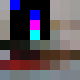

In [24]:
completed_img.resize((completed_img.width * 10,completed_img.height * 10),
                                                    Image.NEAREST)

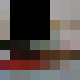

In [26]:
filled_img = to_pil(masked_images[-1].cpu().squeeze(0))
filled_img.resize((filled_img.width * 10,filled_img.height * 10),
                                                    Image.NEAREST)

## Notes

Can try with other datasets as well available here: https://pytorch.org/vision/0.9/datasets.html

Currently, CelebA hit some download limit so couldn't try. can try later again